TEM CNN

In [15]:
import os
import sys
import importlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GaussianNoise, Dropout
from tensorflow.keras.utils import to_categorical
import pandas as pd
import tensorflow as tf

tf.config.optimizer.set_jit(True)

notebooks_dir = os.path.abspath('')
proj_dir = os.path.dirname(notebooks_dir)
raw_data_dir = os.path.join(proj_dir, 'raw_data')
src_dir = os.path.join(proj_dir, 'src')

# Add src_dir to the system path to import helper file
sys.path.insert(1, src_dir)
#import cutpaste_helper
#importlib.reload(cutpaste_helper)

def makeWindows(image_dict,num_windows, width, height):
    '''
    Parameters:
    image_dict: dictionary containing arrays that represent images
    num_windows: the number of windows wanted
    width: the width of the window
    height: the height of the window
    '''
    #Grab windows from the full images from train images
    window_images = []
    for key in image_dict:
    #The 100 windows per image in a list
        for i in range(0, num_windows):
            #Get the width and height of an image
            dimensions = image_dict[key].shape
            image_w = dimensions[1]
            image_h = dimensions[0]
            #Random coordinates
            random_x_coord = random.randint(0, image_w - width)
            random_y_coord = random.randint(0, image_h-height)
            #Takes window out of a random part of the images at the random coordinates
            window = image_dict[key][random_y_coord:random_y_coord + window_y, random_x_coord:random_x_coord + window_x]
            window_images.append(window)
    window_images = np.array(window_images)
    return window_images

def makeWhiteSquares(window_list):
    #Create test window images dict with white square defects
    defect_window_list = np.copy(window_list)
#Fill defect train window images
    for image in defect_window_list:
        #Random sized white square (2D array full of ones)
        sq_random_x = random.randint(5,25)
        sq_random_y = random.randint(5,25)
        white_square = np.ones((sq_random_y,sq_random_x))
        #Random coordinates for the square
        random_x_coord = random.randint(0,window_x-sq_random_x)
        random_y_coord = random.randint(0,window_y-sq_random_y)
        #Replace the coordinates with white square
        image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = white_square
    return defect_window_list

def copyPaste(image):
    copied_image = np.copy(image)
    #Random sized copy-pasted area (2D array)
    sq_random_x = random.randint(5,25)
    sq_random_y = random.randint(5,25)
    #Random coordinates for the square
    random_x_coord = random.randint(0,image.shape[1]-sq_random_x)
    random_y_coord = random.randint(0,image.shape[0]-sq_random_y)
    #Copy the area
    copyArea = image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0]
    #Paste coordinates
    random_x_coord = random.randint(0,window_x-sq_random_x)
    random_y_coord = random.randint(0,window_y-sq_random_y)
    #Paste the area
    copied_image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = copyArea
    return copied_image

def createLabels(image_list, defect_status):
    #Create labels for the images
    labels_list = []
    for image in image_list:
        if defect_status:
            labels_list.append(1)
        else:
            labels_list.append(0)
    labels_list = np.array(labels_list)
    return labels_list
        
def shuffleTwoArrays(image_list, label_list):
    #Shuffles the image and label arrays in the same way
    randomize = np.arange(len(label_list))
    np.random.shuffle(randomize)
    image_list = image_list[randomize]
    label_list = label_list[randomize]
    return (image_list, label_list)

def generateImages(normal_image_list, num_normal, num_defects):
    #A generator that generates images
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(normal_image_list)-1)
            generated_images.append(normal_image_list[random_index])
            generated_labels.append(0)
        for i in range(num_defects):
            random_index = random.randint(0,len(normal_image_list)-1)
            generated_images.append(copyPaste(normal_image_list[random_index]))
            generated_labels.append(1)
        generated_images = np.array(generated_images)
        generated_labels = np.array(generated_labels)
        generated_images, generated_labels = shuffleTwoArrays(generated_images, generated_labels)
        n = generated_images.shape[0]
        yield generated_images, generated_labels.reshape(n, 1)

def valGeneratorImages(test_x, test_y, num_desired):
    while True:
        generated_images = []
        generated_labels = []
        for i in range(num_normal):
            random_index = random.randint(0,len(test_x)-1)
            generated_images.append(test_x[random_index])
            generated_labels.append(test_y[random_index])
        yield generated_images, generated_labels

# Load dictionaries with TEM images
f_name = os.path.join(raw_data_dir, 'test_full_arrays')
#Dict with test image arrays (each key has a value of an array of numbers between 0 and 1)
test_full_arrays = pickle.load(open(f_name, "rb"))
f_name = os.path.join(raw_data_dir, 'train_full_arrays')
#Dict with train image arrays (each key has a value of an array of numbers between 0 and 1)
train_full_arrays = pickle.load(open(f_name, "rb"))

window_x = 118
window_y = 84
num_windows = 100

#Make testing window images and labels
test_window_images = makeWindows(test_full_arrays, num_windows, window_x, window_y)
test_window_labels = createLabels(test_window_images, False)

#Make training window images and labels
train_window_images = makeWindows(train_full_arrays, num_windows ,window_x, window_y)
train_window_labels = createLabels(train_window_images, False)

#Stuff
filters = 32
filter_size = 3
pool_size = 2
epoch_number = 50
my_models = []
my_val_accuracy = []
my_val_loss = []

# Build the model.
train_gen = generateImages(train_window_images, 32, 32)
val_gen = generateImages(test_window_images, 32, 32)
print(f'4 Layers Results: ')
model = Sequential([
  Conv2D(filters, filter_size, input_shape = (84, 118, 1)), 
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 2, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 4, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 8, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Flatten(),
  Dense(2, activation = 'sigmoid')
])


# Compile the model.
model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
history = model.fit(
  train_gen,
  validation_data = val_gen,
  epochs = epoch_number,
  steps_per_epoch=11200/64,
  validation_steps = 11200/64
)

my_models.append(model)
my_val_accuracy.append(history.history['val_accuracy'][-1])
my_val_loss.append(history.history['val_loss'][-1])

# Predict on the first 5 test images.
predictions = model.predict(test_window_images[:5])

# Print our model's predictions.
print("Predictions")
print(np.argmax(predictions, axis=1))

# Check our predictions against the ground truths.
print("Real Labels")
print(test_window_labels[:5])


4 Layers Results: 
Epoch 1/50
175/175 [==============================] - 142s 805ms/step - loss: 0.6944 - accuracy: 0.5060 - val_loss: 0.6909 - val_accuracy: 0.6407
Epoch 2/50
175/175 [==============================] - 176s 1s/step - loss: 0.4863 - accuracy: 0.5013 - val_loss: 0.1967 - val_accuracy: 0.5688
Epoch 3/50
175/175 [==============================] - 182s 1s/step - loss: 0.1498 - accuracy: 0.5148 - val_loss: 0.1001 - val_accuracy: 0.6041
Epoch 4/50
175/175 [==============================] - 177s 1s/step - loss: 0.0828 - accuracy: 0.5204 - val_loss: 0.0777 - val_accuracy: 0.3664
Epoch 5/50
175/175 [==============================] - 164s 938ms/step - loss: 0.0695 - accuracy: 0.4897 - val_loss: 0.1701 - val_accuracy: 0.4503
Epoch 6/50
175/175 [==============================] - 159s 910ms/step - loss: 0.3736 - accuracy: 0.4846 - val_loss: 0.0956 - val_accuracy: 0.4657
Epoch 7/50
175/175 [==============================] - 151s 866ms/step - loss: 0.0756 - accuracy: 0.4687 - val_loss

In [56]:
x,y = next(train_gen)
x.shape

(64, 84, 118, 1)

In [16]:
f_name_types = os.path.join(raw_data_dir, 'Test Data\\test_defect_types.p')
f_name_windows = os.path.join(raw_data_dir, 'Test Data\\test_windows.p')
f_name_labels = os.path.join(raw_data_dir, 'Test Data\\test_labels.p')

test_types = pickle.load(open(f_name_types, "rb"))
test_windows = pickle.load(open(f_name_windows, "rb"))
test_labels = pickle.load(open(f_name_labels, "rb"))

In [17]:
# Predict on the first 5 test images.
predictions = model.predict(test_windows)
pred_class = np.argmax(predictions, axis=1)
# Print our model's predictions.
print(" 1 Predictions")
print(pred_class)

# Check our predictions against the ground truths.
print(" 1 Real Labels")
print(test_labels)

print("Accuracy:")
print(np.sum(pred_class == test_labels)/2500)

79/79 [==============================] - 6s 79ms/step
 1 Predictions
[0 0 0 ... 0 0 0]
 1 Real Labels
[0 0 0 ... 1 1 1]
Accuracy:
0.2732


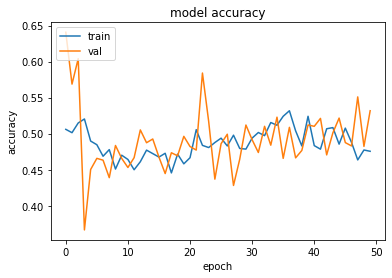

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 82, 116, 32)       320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 41, 58, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 39, 56, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 19, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 17, 26, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 8, 13, 128)      

In [14]:
print(f'8 Layers Results: ')
model = Sequential([
  Conv2D(filters, filter_size, input_shape = (84, 118, 1)), 
  Conv2D(filters * 2, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 4, filter_size),
  Conv2D(filters * 6, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 8, filter_size), 
  Conv2D(filters * 10, filter_size),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 12, filter_size),
  Conv2D(filters * 14, filter_size),
  Flatten(),
  Dense(16, activation = 'sigmoid'),
  Dense(2, activation = 'sigmoid')
])

# Compile the model.
model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

epoch_number = 25

# Train the model.
history = model.fit(
  train_gen,
  validation_data = val_gen,
  epochs = epoch_number,
  steps_per_epoch=11200/128,
  validation_steps = 11200/64
)

my_models.append(model)
my_val_accuracy.append(history.history['val_accuracy'][-1])
my_val_loss.append(history.history['val_loss'][-1])

# Predict on the first 5 test images.
predictions = model.predict(test_window_images[:5])

# Print our model's predictions.
print("Predictions")
print(np.argmax(predictions, axis=1))

# Check our predictions against the ground truths.
print("Real Labels")
print(test_window_labels[:5])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.summary()

8 Layers Results: 
Epoch 1/100
 1/87 [..............................] - ETA: 4:59 - loss: 0.6933 - accuracy: 1.0000

KeyboardInterrupt: 

In [9]:
# Build the model.
train_gen = generateImages(train_window_images, 64, 64)
val_gen = generateImages(test_window_images, 32, 32)


print(f'16 Layers Results: ')
model = Sequential([
  Conv2D(filters, filter_size, input_shape = (84, 118, 1), padding = 'same'), 
  Conv2D(filters * 2, filter_size, padding = 'same'),
  Conv2D(filters * 4, filter_size, padding = 'same'),
  Conv2D(filters * 6, filter_size, padding = 'same'),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 8, filter_size, padding = 'same'), 
  Conv2D(filters * 10, filter_size, padding = 'same'),
  Conv2D(filters * 12, filter_size, padding = 'same'),
  Conv2D(filters * 14, filter_size, padding = 'same'),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters, filter_size, input_shape = (84, 118, 1), padding = 'same'), 
  Conv2D(filters * 16, filter_size, padding = 'same'),
  Conv2D(filters * 18, filter_size, padding = 'same'),
  Conv2D(filters * 20, filter_size, padding = 'same'),
  MaxPooling2D(pool_size = pool_size),
  Conv2D(filters * 22, filter_size, padding = 'same'), 
  Conv2D(filters * 24, filter_size, padding = 'same'),
  Conv2D(filters * 26, filter_size, padding = 'same'),
  Conv2D(filters * 28, filter_size, padding = 'same'),
  MaxPooling2D(pool_size = pool_size),
  Flatten(),
  Dense(16, activation = 'sigmoid'),
  Dense(2, activation = 'sigmoid')
])

# Compile the model.
model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

# Train the model.
history = model.fit(
  train_gen,
  validation_data = val_gen,
  epochs = epoch_number,
  steps_per_epoch=11200/128,
  validation_steps = 11200/64
)

my_models.append(model)
my_val_accuracy.append(history.history['val_accuracy'][-1])
my_val_loss.append(history.history['val_loss'][-1])

# Predict on the first 5 test images.
predictions = model.predict(test_window_images[:5])

# Print our model's predictions.
print("Predictions")
print(np.argmax(predictions, axis=1))

# Check our predictions against the ground truths.
print("Real Labels")
print(test_window_labels[:5])

#Saves the models and model metrics to a dataframe, then saves the dataframe to a csv file and a excel file
d = {'Models' : my_models, 'Value Accuracy' : my_val_accuracy, 'Value Loss' : my_val_loss, "Filters" : filters}
df = pd.DataFrame(data=d, index = model_layers)
df.to_csv(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\10_layers', index=False)
df.to_excel(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\10_layers.xlsx', index=False)
display(df)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.summary()

16 Layers Results: 
Epoch 1/25
 4/87 [>.............................] - ETA: 1:02:13 - loss: 1.1921 - accuracy: 0.7500

KeyboardInterrupt: 

In [34]:
x,y = next(train_gen)
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [7]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

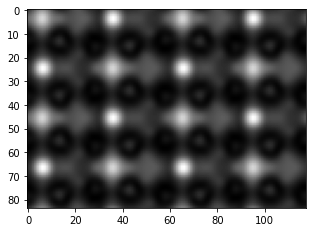

In [59]:
my_array = test_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

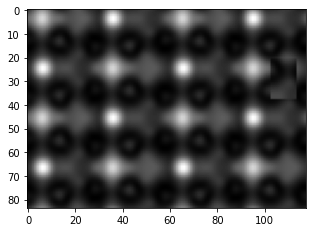

In [58]:
my_array = copyPaste(test_window_images[60])
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

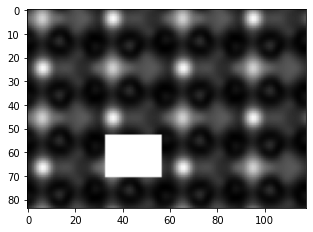

In [60]:
my_array = makeWhiteSquares(test_window_images)[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

In [15]:
test_full_arrays.keys()

dict_keys(['GaAs_10nm_002', 'GaAs_10nm_017', 'GaAs_10nm_014', 'GaAs_10nm_011', 'GaAs_10nm_005', 'GaAs_10nm_008', 'GaAs_10nm_020', 'GaAs_1nm_011', 'GaAs_1nm_005', 'GaAs_1nm_014', 'GaAs_1nm_002', 'GaAs_1nm_017', 'GaAs_1nm_020', 'GaAs_1nm_008', 'GaAs_6nm_014', 'GaAs_6nm_017', 'GaAs_6nm_002', 'GaAs_6nm_011', 'GaAs_6nm_005', 'GaAs_6nm_020', 'GaAs_6nm_008', 'GaAs_2nm_008', 'GaAs_2nm_020', 'GaAs_2nm_011', 'GaAs_2nm_005', 'GaAs_2nm_014', 'GaAs_2nm_017', 'GaAs_2nm_002', 'GaAs_8nm_020', 'GaAs_8nm_008', 'GaAs_8nm_002', 'GaAs_8nm_017', 'GaAs_8nm_014', 'GaAs_8nm_005', 'GaAs_8nm_011', 'GaAs_12nm_008', 'GaAs_12nm_020', 'GaAs_12nm_017', 'GaAs_12nm_002', 'GaAs_12nm_014', 'GaAs_12nm_011', 'GaAs_12nm_005', 'GaAs_4nm_020', 'GaAs_4nm_008', 'GaAs_4nm_014', 'GaAs_4nm_002', 'GaAs_4nm_017', 'GaAs_4nm_011', 'GaAs_4nm_005', 'GaAs_15nm_008', 'GaAs_15nm_020', 'GaAs_15nm_011', 'GaAs_15nm_005', 'GaAs_15nm_002', 'GaAs_15nm_017', 'GaAs_15nm_014'])

In [16]:
train_full_arrays.keys()

dict_keys(['GaAs_10nm_016', 'GaAs_10nm_003', 'GaAs_10nm_001', 'GaAs_10nm_015', 'GaAs_10nm_004', 'GaAs_10nm_010', 'GaAs_10nm_013', 'GaAs_10nm_007', 'GaAs_10nm_006', 'GaAs_10nm_012', 'GaAs_10nm_021', 'GaAs_10nm_009', 'GaAs_10nm_019', 'GaAs_10nm_018', 'GaAs_1nm_013', 'GaAs_1nm_007', 'GaAs_1nm_006', 'GaAs_1nm_012', 'GaAs_1nm_004', 'GaAs_1nm_010', 'GaAs_1nm_001', 'GaAs_1nm_015', 'GaAs_1nm_016', 'GaAs_1nm_003', 'GaAs_1nm_019', 'GaAs_1nm_018', 'GaAs_1nm_009', 'GaAs_1nm_021', 'GaAs_6nm_001', 'GaAs_6nm_015', 'GaAs_6nm_003', 'GaAs_6nm_016', 'GaAs_6nm_006', 'GaAs_6nm_012', 'GaAs_6nm_013', 'GaAs_6nm_007', 'GaAs_6nm_004', 'GaAs_6nm_010', 'GaAs_6nm_009', 'GaAs_6nm_021', 'GaAs_6nm_018', 'GaAs_6nm_019', 'GaAs_2nm_018', 'GaAs_2nm_019', 'GaAs_2nm_021', 'GaAs_2nm_009', 'GaAs_2nm_006', 'GaAs_2nm_012', 'GaAs_2nm_013', 'GaAs_2nm_007', 'GaAs_2nm_004', 'GaAs_2nm_010', 'GaAs_2nm_001', 'GaAs_2nm_015', 'GaAs_2nm_003', 'GaAs_2nm_016', 'GaAs_8nm_009', 'GaAs_8nm_021', 'GaAs_8nm_019', 'GaAs_8nm_018', 'GaAs_8nm_016',